# **IRB Retail Mortgage**
# **PD Model Development**


In the previous notebooks, we completed the full data preparation and feature engineering required for retail PD modelling. This included portfolio-level analysis, target definition, exploratory data analysis, variable selection, monotonic binning, Weight of Evidence (WOE) transformation, and missing value treatment across categorical, numerical count, and numerical continuous variables.

All candidate predictors have now been transformed into stable, interpretable, and model-ready WOE variables. The objective of this notebook is to develop the Probability of Default (PD) model using logistic regression. Specifically, we will:
- Assemble the final modelling dataset using WOE-transformed variables
- Perform univariate sanity checks on coefficient signs
- Build a baseline multivariate logistic regression model
- Assess statistical significance and economic intuition
- Iteratively refine the model by removing weak or unstable predictors

## **Loading the Dataset**

In [2]:
# importing the required modules
import sys
sys.path.append("..")

from src.config import *
from src.utility_functions import *

In [3]:
# loading the dataset after EDA and preliminary variable strategy decisions
model_df = save_as_pickle_if_not_exists_and_load(pickle_file_path = f"{main_dir}/data/processed/mortgage_model_data_woe.pkl")
model_df.head(5)

Pickle file already exists at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//data/processed/mortgage_model_data_woe.pkl
(2260668, 84)


,id,term,loan_amnt,int_rate,installment,grade,sub_grade,purpose,verification_status,annual_inc,emp_length,home_ownership,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,t0,default_flag,clubbed_term,clubbed_sub_grade,clubbed_purpose,clubbed_verification_status,clubbed_home_ownership,clubbed_emp_length,clubbed_term_woe,clubbed_term_iv,clubbed_sub_grade_woe,clubbed_sub_grade_iv,clubbed_purpose_woe,clubbed_purpose_iv,clubbed_verification_status_woe,clubbed_verification_status_iv,clubbed_home_ownership_woe,clubbed_home_ownership_iv,clubbed_emp_length_woe,clubbed_emp_length_iv,delinq_2yrs_adj,clubbed_delinq_2yrs,clubbed_delinq_2yrs_woe,clubbed_delinq_2yrs_iv,inq_last_6mths_adj,clubbed_inq_last_6mths,clubbed_inq_last_6mths_woe,clubbed_inq_last_6mths_iv,pub_rec_adj,clubbed_pub_rec,clubbed_pub_rec_woe,clubbed_pub_rec_iv,open_acc_adj,clubbed_open_acc,clubbed_open_acc_woe,clubbed_open_acc_iv,total_acc_adj,clubbed_total_acc,clubbed_total_acc_woe,clubbed_total_acc_iv,loan_amnt_category,loan_amnt_bin_id,loan_amnt_woe,int_rate_category,int_rate_bin_id,int_rate_woe,installment_category,installment_bin_id,installment_woe,annual_inc_category,annual_inc_bin_id,dti_category,dti_bin_id,revol_bal_category,revol_bal_bin_id,revol_bal_woe,revol_util_category,revol_util_bin_id,dti_bin_id_adj,annual_inc_bin_id_adj,revol_util_bin_id_adj,dti_woe,annual_inc_woe,revol_util_woe
774204,139972821,60 months,10400.0000,22.3500,289.3200,D,D5,debt_consolidation,Not Verified,0.0000,NaN,RENT,NaN,1.0000,1.0000,5.0000,0.0000,0.0000,NaN,23.0000,2018-09-30,0,60 months,D5,1. medium_risk,Not Verified,1. rent,unknown,-0.3569,0.0419,-0.6693,0.0122,-0.0923,0.0051,0.4333,0.0524,-0.1773,0.0133,-0.2178,0.0033,1,1,-0.0810,0.0008,1,1,-0.1399,0.0053,0,0,0.0475,0.0019,2. 3_5,2. 3_5,0.1796,0.0028,4. 21_30,4. 21_30,-0.0119,0.0000,10025.0 - 15000.0,3,-0.0778,20.9 - 30.99,8,-0.9367,230.64 - 327.69,2,0.0459,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562
1488539,135666561,60 months,12000.0000,17.4700,301.2800,D,D1,credit_card,Not Verified,0.0000,NaN,RENT,NaN,0.0000,0.0000,1.0000,0.0000,0.0000,NaN,3.0000,2018-06-30,0,60 months,D1,0. low_risk,Not Verified,1. rent,unknown,-0.3569,0.0419,-0.4494,0.0086,0.2187,0.0135,0.4333,0.0524,-0.1773,0.0133,-0.2178,0.0033,0,0,0.0289,0.0007,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,1. 0_5,1. 0_5,0.1930,0.0005,10025.0 - 15000.0,3,-0.0778,15.1 - 17.47,6,-0.4327,230.64 - 327.69,2,0.0459,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562
2081649,122649959,36 months,16800.0000,9.9300,541.5400,B,B2,debt_consolidation,Not Verified,0.0000,NaN,MORTGAGE,NaN,0.0000,0.0000,2.0000,0.0000,0.0000,NaN,10.0000,2017-11-30,0,36 months,B2,1. medium_risk,Not Verified,0. owned,unknown,0.1765,0.0207,0.6412,0.0180,-0.0923,0.0051,0.4333,0.0524,0.1304,0.0098,-0.2178,0.0033,0,0,0.0289,0.0007,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,2. 6_10,2. 6_10,0.1058,0.0009,15025.0 - 40000.0,4,-0.0971,8.88 - 10.47,2,0.6826,327.7 - 1246.76,3,-0.0898,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562
2100238,123937016,36 months,20000.0000,10.4200,649.3000,B,B3,debt_consolidation,Not Verified,0.0000,NaN,MORTGAGE,NaN,1.0000,0.0000,2.0000,0.0000,0.0000,NaN,13.0000,2017-11-30,0,36 months,B3,1. medium_risk,Not Verified,0. owned,unknown,0.1765,0.0207,0.4299,0.0091,-0.0923,0.0051,0.4333,0.0524,0.1304,0.0098,-0.2178,0.0033,1,1,-0.0810,0.0008,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,3. 11_20,3. 11_20,0.0264,0.0002,15025.0 - 40000.0,4,-0.0971,8.88 - 10.47,2,0.6826,327.7 - 1246.76,3,-0.0898,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562
1654329,79967,36 months,5000.0000,7.4300,155.3800,A,A2,other,Not Verified,NaN,< 1 year,NONE,1.0000,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,2007-08-31,0,36 months,A2,2. high_risk,Not Verified,2. other,0. <2_YEARS,0.1765,0.0207

In [4]:
# defining the variable lists
# categorical variables
clubbed_categorical_vars = ['clubbed_term', 'clubbed_sub_grade', 'clubbed_purpose', 'clubbed_verification_status', 'clubbed_home_ownership', 'clubbed_emp_length']

# numerical continuous variables 
num_continuous_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util']

# numerical count variables 
num_count_vars = ['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']

final_var_list = [f"{i}_woe" for i in clubbed_categorical_vars] + [f"clubbed_{i}_woe" for i in num_count_vars] + [f"{i}_woe" for i in num_continuous_vars]
model_df[final_var_list].isna().sum()

clubbed_term_woe                   0
clubbed_sub_grade_woe              0
clubbed_purpose_woe                0
clubbed_verification_status_woe    0
clubbed_home_ownership_woe         0
clubbed_emp_length_woe             0
clubbed_delinq_2yrs_woe            0
clubbed_inq_last_6mths_woe         0
clubbed_open_acc_woe               0
clubbed_pub_rec_woe                0
clubbed_total_acc_woe              0
loan_amnt_woe                      0
int_rate_woe                       0
installment_woe                    0
annual_inc_woe                     0
dti_woe                            0
revol_bal_woe                      0
revol_util_woe                     0
dtype: int64

## **Single Factor Analysis**

- The PD model is developed using a structured Single Factor Analysis (SFA) and Multi-Factor Analysis (MFA) framework. In SFA, each candidate WOE-transformed variable is evaluated individually for sign logic, statistical relevance, and economic intuition. Variables failing these checks are excluded.

- Variables that pass SFA are then evaluated jointly through MFA, starting with a parsimonious core model and gradually expanding model size. The final model is selected based on stability, interpretability, and marginal contribution, rather than purely statistical metrics.


In [5]:
sfa_results = pd.DataFrame(columns=['variable', 'coefficient', 'p_value', 'sign', 'gini', 'corr', 'sign_corr'])
for var in final_var_list:

    X = sm.add_constant(model_df[var])
    y = model_df['default_flag']

    logit_model = sm.Logit(y, X).fit(disp=0)

    # summary statistics - p_values, coefficients, sign, somersd (gini), etc
    coef = logit_model.params[var]
    p_value = logit_model.pvalues[var]
    gini = 2 * roc_auc_score(y, logit_model.predict(X)) - 1
    corr = np.corrcoef(model_df[var], y)[0, 1]

    sfa_results = pd.concat([sfa_results, pd.DataFrame({'variable': var, 'coefficient': coef, 'p_value': p_value, 'sign': np.sign(coef), 'gini': gini, 'corr': corr, 'sign_corr': np.sign(corr)}, index=[0])], ignore_index=True)

sfa_results.sort_values(by=['p_value', 'gini'], ascending=[True, False], inplace=True)

In [6]:
sfa_results

,variable,coefficient,p_value,sign,gini,corr,sign_corr
1,clubbed_sub_grade_woe,-1.0000,0.0000,-1.0000,0.3828,-0.2130,-1.0000
12,int_rate_woe,-1.0000,0.0000,-1.0000,0.3567,-0.1955,-1.0000
3,clubbed_verification_status_woe,-1.0000,0.0000,-1.0000,0.1578,-0.0940,-1.0000
7,clubbed_inq_last_6mths_woe,-1.0000,0.0000,-1.0000,0.1275,-0.0877,-1.0000
15,dti_woe,-1.0000,0.0000,-1.0000,0.1190,-0.0673,-1.0000
0,clubbed_term_woe,-1.0000,0.0000,-1.0000,0.1175,-0.0841,-1.0000
17,revol_util_woe,-1.0000,0.0000,-1.0000,0.1171,-0.0673,-1.0000
14,annual_inc_woe,-1.0000,0.0000,-1.0000,0.1031,-0.0593,-1.0000
4,clubbed_home_ownership_woe,-1.0000,0.0000,-1.0000,0.0751,-0.0498,-1.0000
13,installment_woe,-1.0000,0.0000,-1.0000,0.0672,-0.0438,-1.0000


- Single Factor Analysis (SFA) was conducted using WOE-transformed predictors. All candidate variables exhibit intuitive sign behaviour, with negative correlation between WOE and default flag, indicating that higher WOE values are consistently associated with lower default risk.

- Univariate discriminatory power, measured using Gini, is meaningful across all variables, with the strongest predictors being credit quality and pricing-related variables such as sub-grade, interest rate, verification status, and recent inquiry behaviour. Even the weakest variables demonstrate Gini values above 2%, indicating non-trivial standalone predictive power.

Overall, no variable fails SFA on sign logic or lack of explanatory power. All variables are therefore retained for further evaluation in the multivariate modelling stage.


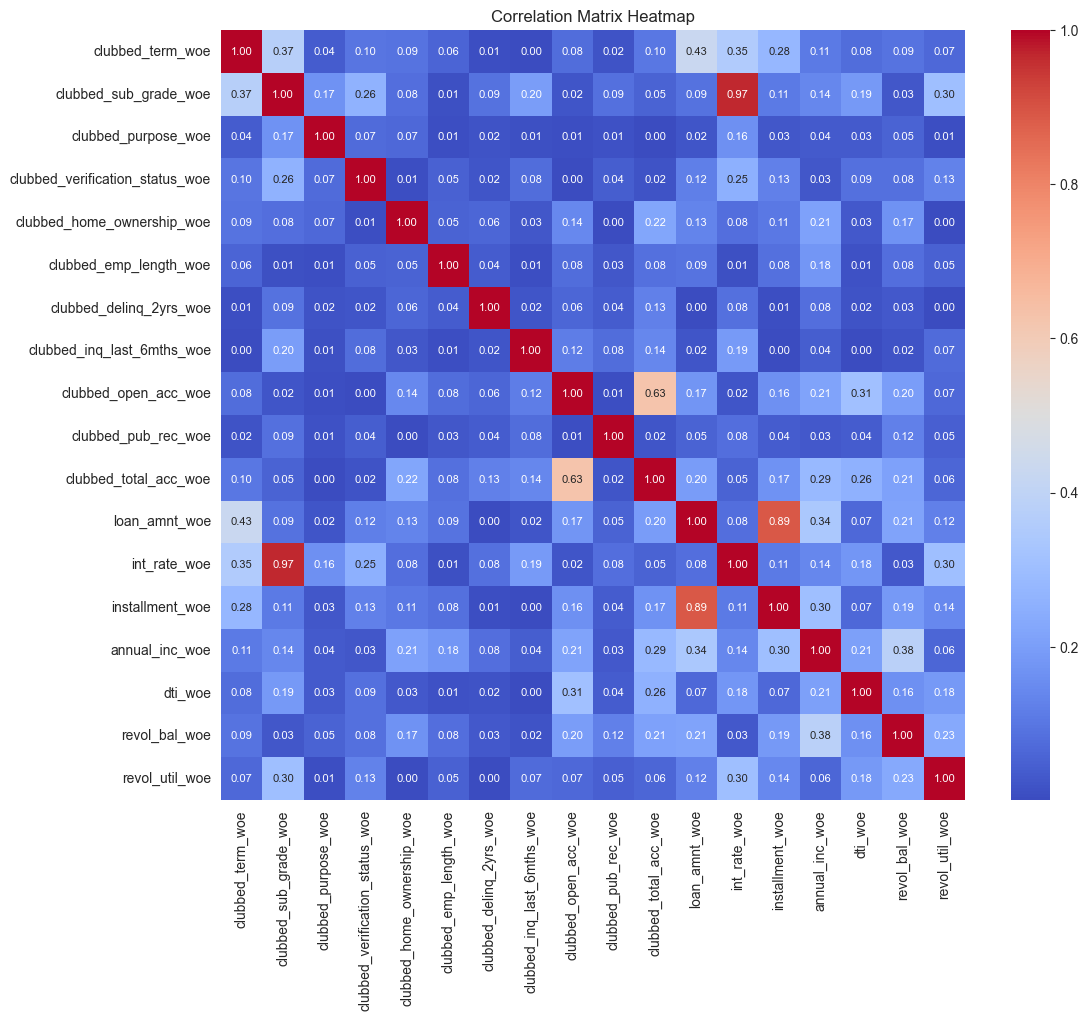

Highly correlated variable pairs (correlation > 0.6): [('clubbed_sub_grade_woe', 'int_rate_woe'), ('clubbed_open_acc_woe', 'clubbed_total_acc_woe'), ('loan_amnt_woe', 'installment_woe')]


In [7]:
# checking the correlation between variables and flagging those with more than 0.6 correlation
corr_matrix = model_df[final_var_list].corr().abs()
high_corr_var_pairs = np.where(corr_matrix > 0.6)
high_corr_var_pairs = [(final_var_list[i], final_var_list[j]) for i, j in zip(*high_corr_var_pairs) if i != j and i < j]

# heatmap on corr matrix 
fig = plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 8})
plt.title('Correlation Matrix Heatmap')
plt.show()

print("Highly correlated variable pairs (correlation > 0.6):", high_corr_var_pairs)

A correlation analysis shows that the majority of variable pairs exhibit low to moderate correlations, indicating that the feature engineering process has successfully reduced redundant information.

Three variable pairs exhibit relatively high correlation (above 60%):
- Sub-grade and interest rate, reflecting the direct linkage between borrower credit quality and loan pricing
- Open accounts and total accounts, both capturing dimensions of borrower credit depth
- Loan amount and installment amount, where installment is mechanically derived from loan amount and term

These relationships are economically intuitive and expected in retail credit portfolios. No variables are removed at this stage, as correlation analysis serves as a diagnostic rather than a selection criterion. Potential multicollinearity will be explicitly addressed during multi-factor analysis (MFA) through coefficient stability checks and variance inflation factor (VIF) assessment. Variables forming highly correlated pairs will not be simultaneously retained in the final model.


### **Multi-Factor Analysis**

In [8]:
num_vars = [f"clubbed_{i}_woe" for i in num_count_vars] + [f"{i}_woe" for i in num_continuous_vars]
cat_vars = [f"{i}_woe" for i in clubbed_categorical_vars] 

economic_driver_map = {
    # credit quality
    'clubbed_sub_grade_woe': 'credit_quality',
    'int_rate_woe': 'credit_quality',

    # behavioural
    'clubbed_delinq_2yrs_woe': 'behavioural',
    'clubbed_inq_last_6mths_woe': 'behavioural',
    'clubbed_pub_rec_woe': 'behavioural',
    'clubbed_open_acc_woe': 'behavioural',
    'clubbed_total_acc_woe': 'behavioural',
    'revol_util_woe': 'behavioural',
    'revol_bal_woe': 'behavioural',

    # affordability / capacity
    'annual_inc_woe': 'affordability',
    'dti_woe': 'affordability',
    'installment_woe': 'affordability',

    # exposure / loan structure
    'loan_amnt_woe': 'exposure',
    'clubbed_term_woe': 'exposure',

    # customer profile / application
    'clubbed_home_ownership_woe': 'customer_profile',
    'clubbed_emp_length_woe': 'customer_profile',
    'clubbed_verification_status_woe': 'customer_profile',
    'clubbed_purpose_woe': 'customer_profile'
}

In [9]:
# combinations of 4 variables
combinations_list4 = list(combinations(final_var_list, 4))
# filtered combinations after applying exclusion and category constraints
filtered_combinations4 = [combo for combo in combinations_list4 if not violates_exclusion(combo, high_corr_var_pairs) and not violates_categories(combo, num_vars, cat_vars)]
print(len(combinations_list4), len(filtered_combinations4))

# resjob4 = Parallel(n_jobs=-1)(delayed(run_mfa_combination)(model_df, list(combo)) for combo in filtered_combinations4) # taking more time than simple for loop, may be good for combination of larger sizes
resjob4 = []
for combo in filtered_combinations4:
    result_df = run_mfa_combination(model_df, list(combo))
    resjob4.append(result_df)
mfa_results_4 = pd.concat([df for df in resjob4 if not df.empty], ignore_index=True)

3060 905


In [10]:
# checking the frequency of variables
survivor_frequency = mfa_results_4.sort_values(by='gini', ascending=False)['variable'].value_counts(dropna=False).to_frame().reset_index()
survivor_frequency['cat_vs_num'] = survivor_frequency.variable.apply(lambda x: 'categorical' if x in cat_vars else 'numerical')
survivor_frequency['economic_driver'] = survivor_frequency.variable.map(economic_driver_map)
survivor_frequency['corr_with_default'] = survivor_frequency.variable.map(sfa_results.set_index('variable')['corr'])
survivor_frequency.sort_values(by=['count', 'economic_driver','corr_with_default'], inplace=True)
survivor_frequency

,variable,count,cat_vs_num,economic_driver,corr_with_default
17,int_rate_woe,108,numerical,credit_quality,-0.1955
16,loan_amnt_woe,124,numerical,exposure,-0.0392
15,clubbed_total_acc_woe,128,numerical,behavioural,-0.0170
14,clubbed_open_acc_woe,131,numerical,behavioural,-0.0227
13,installment_woe,136,numerical,affordability,-0.0438
12,dti_woe,143,numerical,affordability,-0.0673
11,clubbed_inq_last_6mths_woe,148,numerical,behavioural,-0.0877
10,revol_util_woe,148,numerical,behavioural,-0.0673
9,revol_bal_woe,149,numerical,behavioural,-0.0248
8,clubbed_pub_rec_woe,150,numerical,behavioural,-0.0364


Following the size-4 multi-factor analysis, variables were shortlisted based on a combination of statistical performance (frequency of survival, Gini contribution, sign stability), multicollinearity diagnostics, and economic interpretability.

- Highly correlated variable pairs were resolved by selecting the more robust and economically fundamental driver. In particular, sub-grade was retained over interest rate due to its stronger discriminatory power and closer linkage to intrinsic borrower credit quality.

- Customer profile variables emerged as consistently strong drivers across accepted models. Exposure was represented via loan term, which outperformed loan amount in capturing risk horizon effects. Behavioural risk was covered through a balanced set of delinquency and revolving credit stress indicators, while affordability was represented by income and debt-to-income ratio.

The resulting variable set provides broad coverage across credit quality, customer profile, behavioural performance, affordability, and exposure dimensions, and forms a stable and interpretable foundation for higher-order MFA.

In [11]:
selected_vars = [ # customer profile
                  'clubbed_home_ownership_woe', 'clubbed_purpose_woe', 'clubbed_verification_status_woe',

                  # credit quality
                  'clubbed_sub_grade_woe',

                  # exposure
                  'clubbed_term_woe',

                  # behavioural
                  'clubbed_inq_last_6mths_woe', 'revol_util_woe', 'clubbed_delinq_2yrs_woe',

                  # affordability
                  'annual_inc_woe', 'dti_woe']

In [12]:
mfa_results = {'4': mfa_results_4}

for comb_size in [5,6,7,8]:
    print(f"Processing combinations of size {comb_size}...")
    
    # combinations of variables
    combinations_list = list(combinations(selected_vars, comb_size))
    # filtered combinations after applying exclusion and category constraints
    filtered_combinations = [combo for combo in combinations_list if not violates_exclusion(combo, high_corr_var_pairs) and not violates_categories(combo, num_vars, cat_vars)]
    print(len(combinations_list), len(filtered_combinations))

    resjob = []
    for combo in filtered_combinations:
        result_df = run_mfa_combination(model_df, list(combo))
        resjob.append(result_df)
    
    mfa_results_comb_size = pd.concat([df for df in resjob if not df.empty], ignore_index=True)
    mfa_results[str(comb_size)] = mfa_results_comb_size

Processing combinations of size 5...
252 200
Processing combinations of size 6...
210 200
Processing combinations of size 7...
120 120
Processing combinations of size 8...
45 45


In [13]:
for i in [4,5,6,7,8]:
    print(i, mfa_results[f"{i}"].gini.max())

4 0.4019761294693209
5 0.40511282754706435
6 0.4067638623797756
7 0.4077854011277293
8 0.4082397605916759


In [15]:
display(mfa_results['4'].sort_values(by='gini', ascending =False).head(4))
display(mfa_results['5'].sort_values(by='gini', ascending =False).head(5))
display(mfa_results['6'].sort_values(by='gini', ascending =False).head(6))
display(mfa_results['7'].sort_values(by='gini', ascending =False).head(7))
display(mfa_results['8'].sort_values(by='gini', ascending =False).head(8))

,variable,coefficients,p_values,contribution_pct,vif,max_pval,max_vif,gini,sign_check,min_contribution,max_contribution
1240,clubbed_sub_grade_woe,-0.9011,0.0000,0.6385,1.1636,0.0000,1.1636,0.4020,True,0.1140,0.6385
1241,clubbed_verification_status_woe,-0.4534,0.0000,0.1233,1.0888,0.0000,1.1636,0.4020,True,0.1140,0.6385
1242,clubbed_inq_last_6mths_woe,-0.5219,0.0000,0.1140,1.0542,0.0000,1.1636,0.4020,True,0.1140,0.6385
1243,annual_inc_woe,-0.7127,0.0000,0.1242,1.0328,0.0000,1.1636,0.4020,True,0.1140,0.6385


,variable,coefficients,p_values,contribution_pct,vif,max_pval,max_vif,gini,sign_check,min_contribution,max_contribution
212,clubbed_sub_grade_woe,-0.8955,0.0000,0.5940,1.1693,0.0000,1.1693,0.4051,True,0.0810,0.5940
210,clubbed_home_ownership_woe,-0.6410,0.0000,0.0810,1.0524,0.0000,1.1693,0.4051,True,0.0810,0.5940
211,clubbed_verification_status_woe,-0.4592,0.0000,0.1169,1.0890,0.0000,1.1693,0.4051,True,0.0810,0.5940
213,clubbed_inq_last_6mths_woe,-0.5333,0.0000,0.1090,1.0550,0.0000,1.1693,0.4051,True,0.0810,0.5940
214,annual_inc_woe,-0.6075,0.0000,0.0991,1.0746,0.0000,1.1693,0.4051,True,0.0810,0.5940


,variable,coefficients,p_values,contribution_pct,vif,max_pval,max_vif,gini,sign_check,min_contribution,max_contribution
454,annual_inc_woe,-0.5218,0.0000,0.0814,1.1192,0.0000,1.2008,0.4068,True,0.0631,0.5581
453,clubbed_inq_last_6mths_woe,-0.5460,0.0000,0.1068,1.0560,0.0000,1.2008,0.4068,True,0.0631,0.5581
452,clubbed_sub_grade_woe,-0.8797,0.0000,0.5581,1.2008,0.0000,1.2008,0.4068,True,0.0631,0.5581
451,clubbed_verification_status_woe,-0.4424,0.0000,0.1077,1.0920,0.0000,1.2008,0.4068,True,0.0631,0.5581
450,clubbed_home_ownership_woe,-0.6859,0.0000,0.0829,1.0602,0.0000,1.2008,0.4068,True,0.0631,0.5581
455,dti_woe,-0.3756,0.0000,0.0631,1.0910,0.0000,1.2008,0.4068,True,0.0631,0.5581


,variable,coefficients,p_values,contribution_pct,vif,max_pval,max_vif,gini,sign_check,min_contribution,max_contribution
441,clubbed_home_ownership_woe,-0.6883,0.0000,0.0799,1.0602,0.0000,1.3237,0.4078,True,0.0452,0.5255
442,clubbed_verification_status_woe,-0.4362,0.0000,0.1021,1.0942,0.0000,1.3237,0.4078,True,0.0452,0.5255
443,clubbed_sub_grade_woe,-0.8618,0.0000,0.5255,1.3237,0.0000,1.3237,0.4078,True,0.0452,0.5255
444,clubbed_inq_last_6mths_woe,-0.5787,0.0000,0.1088,1.0804,0.0000,1.3237,0.4078,True,0.0452,0.5255
445,revol_util_woe,-0.2638,0.0000,0.0452,1.1812,0.0000,1.3237,0.4078,True,0.0452,0.5255
446,annual_inc_woe,-0.5625,0.0000,0.0843,1.1434,0.0000,1.3237,0.4078,True,0.0452,0.5255
447,dti_woe,-0.3353,0.0000,0.0541,1.1184,0.0000,1.3237,0.4078,True,0.0452,0.5255


,variable,coefficients,p_values,contribution_pct,vif,max_pval,max_vif,gini,sign_check,min_contribution,max_contribution
259,clubbed_inq_last_6mths_woe,-0.5798,0.0000,0.1055,1.0804,0.0000,1.3399,0.4082,True,0.0274,0.5064
256,clubbed_home_ownership_woe,-0.7030,0.0000,0.0791,1.0631,0.0000,1.3399,0.4082,True,0.0274,0.5064
263,dti_woe,-0.3380,0.0000,0.0528,1.1187,0.0000,1.3399,0.4082,True,0.0274,0.5064
262,annual_inc_woe,-0.5805,0.0000,0.0843,1.1506,0.0000,1.3399,0.4082,True,0.0274,0.5064
261,clubbed_delinq_2yrs_woe,-0.5945,0.0000,0.0274,1.0213,0.0000,1.3399,0.4082,True,0.0274,0.5064
260,revol_util_woe,-0.2738,0.0000,0.0455,1.1824,0.0000,1.3399,0.4082,True,0.0274,0.5064
258,clubbed_sub_grade_woe,-0.8577,0.0000,0.5064,1.3399,0.0000,1.3399,0.4082,True,0.0274,0.5064
257,clubbed_verification_status_woe,-0.4373,0.0000,0.0991,1.0942,0.0000,1.3399,0.4082,True,0.0274,0.5064


### **Selected Combination**

While marginal Gini improvements are observed as the number of variables increases beyond six, these gains are economically insignificant relative to the additional model complexity introduced.

A six-factor specification achieves a strong balance between discriminatory power, economic interpretability, and contribution stability, and is therefore selected as the preferred specification.

In [26]:
selected_combination = mfa_results['6'].sort_values(by='gini', ascending =False).head(6)['variable'].to_list()
X = sm.add_constant(model_df[selected_combination]).copy()
y = model_df['default_flag'].copy()
model = sm.Logit(y, X).fit(disp=0)

coef = model.params
pvals = model.pvalues
vif_df = compute_vif(X[selected_combination])
vif_df.set_index('variable', inplace=True)

y_pred = model.predict(X).copy()
gini = 2 * roc_auc_score(y, y_pred) - 1

stds = model_df[selected_combination].std()
abs_contrib = (coef.abs() * stds)
contrib_pct = abs_contrib / abs_contrib.sum()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           default_flag   No. Observations:              2260668
Model:                          Logit   Df Residuals:                  2260661
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                 0.07810
Time:                        15:02:47   Log-Likelihood:            -7.6118e+05
converged:                       True   LL-Null:                   -8.2566e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.0023      0.002   -907.929      0.000      -2.007      -1.998
annual_inc_woe                     -0.5218      0.012    -43.220      0.000      -0.545      -0.498
clubbed_inq_last_6mths_woe         -0.5460      0.008    -67.838      0.000      -0.562      -0.530
clubbed_sub_grade_woe              -0.8797      0.003   -259.357      0.000      -0.886      -0.873
clubbed_verification_status_woe    -0.4424      0.007    -59.030      0.000      -0.457      -0.428
clubbed_home_ownership_woe         -0.6859      0.014    -48.390      0.000      -0.714      -0.658
dti_woe                            -0.3756      0.010    -35.836      0.000      -0.396      -0.355
===================================================================================================
"""

In [29]:
result = pd.DataFrame({'variable': ['const'] + selected_combination})
result.set_index('variable', inplace=True)
result = result.merge(coef.to_frame('coefficient'), left_index=True, right_index=True, how='left').merge(
    pvals.to_frame('p_values'), left_index=True, right_index=True, how='left').merge(
        vif_df, left_index=True, right_index=True, how='left').merge(
            contrib_pct.to_frame('contribution_pct'), left_index=True, right_index=True, how='left')

result['gini'] = gini
result['economic_driver'] = result.index.map(economic_driver_map)
result.reset_index(inplace=True)
result

,variable,coefficient,p_values,vif,contribution_pct,gini,economic_driver
0,const,-2.0023,0.0000,NaN,NaN,0.4068,NaN
1,annual_inc_woe,-0.5218,0.0000,1.1192,0.0814,0.4068,affordability
2,clubbed_inq_last_6mths_woe,-0.5460,0.0000,1.0560,0.1068,0.4068,behavioural
3,clubbed_sub_grade_woe,-0.8797,0.0000,1.2008,0.5581,0.4068,credit_quality
4,clubbed_verification_status_woe,-0.4424,0.0000,1.0920,0.1077,0.4068,customer_profile
5,clubbed_home_ownership_woe,-0.6859,0.0000,1.0602,0.0829,0.4068,customer_profile
6,dti_woe,-0.3756,0.0000,1.0910,0.0631,0.4068,affordability


The selected six variables jointly achieve:

- Strong discriminatory power (Gini ≈ 40.7%),
- Statistical robustness (all coefficients significant at <1%),
- Low multicollinearity (all VIFs ≈ 1.0–1.2),
- Stable and intuitive contribution structure, avoiding over-concentration in a single driver.


The final model captures diverse and complementary risk dimensions, ensuring no single economic theme dominates the scorecard.

- `clubbed_sub_grade_woe`
    - Primary credit quality indicator
    - Largest contributor (~56%), reflecting underwriting risk differentiation

- `clubbed_verification_status_woe`
    - Customer profile / documentation strength
    - Captures selection effects and information asymmetry

- `clubbed_inq_last_6mths_woe`
    - Recent behavioural stress indicator
    - Adds incremental risk sensitivity beyond static profile variables

- `annual_inc_woe`
    - Affordability / repayment capacity
    - Stabilises credit quality dominance

- `clubbed_home_ownership_woe`
    - Socio-economic stability proxy
    - Lowers volatility and improves interpretability

- `dti_woe`
    - Leverage stress measure`
    - Complements income by capturing obligations burden

#### **In-Sample Performance Diagnostics**

In [32]:
# printing final model metrics in percentage format
print(f"AUC: {round(roc_auc_score(y, y_pred)*100, 2)}%")
print(f"Final Model Gini: {round(gini*100, 2)}%")

AUC: 70.34%
Final Model Gini: 40.68%


KS Statistic: 0.2919


,decile,population,defaults,avg_pd,obs_default_rate,cum_good,cum_bad,ks
0,0,226447,4816,0.0217,0.0213,0.1113,0.0179,0.0934
1,1,225904,9532,0.0418,0.0422,0.2200,0.0533,0.1667
2,2,225856,13761,0.0600,0.0609,0.3265,0.1044,0.2221
3,3,226127,17294,0.0773,0.0765,0.4313,0.1686,0.2628
4,4,226028,21433,0.0948,0.0948,0.5341,0.2481,0.2860
5,5,226122,25732,0.1134,0.1138,0.6347,0.3437,0.2911
6,6,225994,30264,0.1341,0.1339,0.7330,0.4560,0.2770
7,7,226301,35934,0.1597,0.1588,0.8286,0.5894,0.2392
8,8,225845,44735,0.1975,0.1981,0.9196,0.7555,0.1641
9,9,226044,65859,0.2912,0.2914,1.0000,1.0000,0.0000


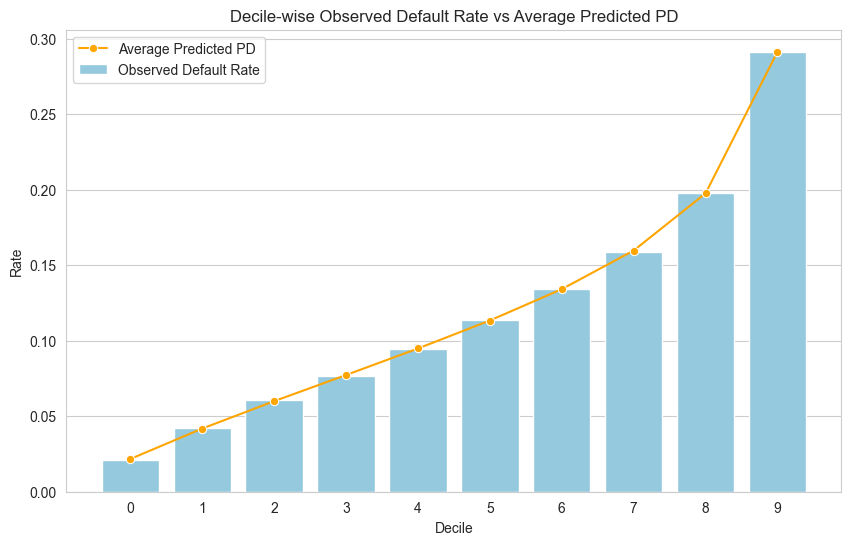

In [36]:
# decile summary
model_df['pd_hat'] = y_pred
model_df['decile'] = pd.qcut(model_df['pd_hat'], q=10, labels=False, duplicates='drop')
decile_summary = model_df.groupby('decile').agg(
        population=('default_flag', 'count'),
        defaults=('default_flag', 'sum'),
        avg_pd=('pd_hat', 'mean')).reset_index()

decile_summary['obs_default_rate'] = decile_summary['defaults'] / decile_summary['population']
decile_summary = decile_summary.sort_values('decile').reset_index(drop=True)

# KS Statistic
fpr, tpr, thresholds = roc_curve(y, model_df['pd_hat'])
ks_stat = max(tpr - fpr)
print(f"KS Statistic: {ks_stat:.4f}")


decile_summary['cum_good'] = (decile_summary['population'] - decile_summary['defaults']).cumsum() / (decile_summary['population'] - decile_summary['defaults']).sum()
decile_summary['cum_bad'] = decile_summary['defaults'].cumsum() / decile_summary['defaults'].sum()
decile_summary['ks'] = abs(decile_summary['cum_bad'] - decile_summary['cum_good'])
display(decile_summary)

# plotting the decile summary
fig_decile = plt.figure(figsize=(10, 6))
sns.barplot(x='decile', y='obs_default_rate', data=decile_summary, color='skyblue', label='Observed Default Rate')
sns.lineplot(x='decile', y='avg_pd', data=decile_summary, color='orange', marker='o', label='Average Predicted PD')
plt.title('Decile-wise Observed Default Rate vs Average Predicted PD')
plt.xlabel('Decile')
plt.ylabel('Rate')
plt.legend()
plt.show()

The final six-factor PD model demonstrates strong discriminatory power and stable risk ranking across the portfolio. The model achieves an AUC of 70.34% and a corresponding Gini coefficient of 40.68%. These results confirm that the selected variable set provides meaningful separation between defaulting and non-defaulting accounts while maintaining economic interpretability and modelling discipline.

Decile analysis further validates the robustness of the model. Observed default rates increase monotonically across all ten score deciles, ranging from approximately 2% in the lowest-risk decile to nearly 29% in the highest-risk decile. The average predicted PD closely tracks observed default behaviour at each decile level, indicating strong relative calibration even prior to formal calibration adjustments. This confirms that the model effectively ranks borrowers by risk and is suitable for downstream applications such as risk segmentation and policy cut-offs.

The KS statistic of ~29% indicates good separation between cumulative good and bad distributions. While marginal improvements in Gini are observed when additional variables are introduced, these gains are economically insignificant relative to the added complexity. The six-factor specification therefore represents an optimal balance between predictive power, stability, and interpretability, making it well-suited for regulatory and production use.

**Key Takeaways**
- Strong discriminatory power (Gini ≈ 41%) with stable rank ordering
- Monotonic increase in observed default rates across score deciles
- Predicted PDs closely aligned with observed behaviour
- No evidence of overfitting or unstable segmentation
- Model is fit for calibration and validation in subsequent steps

## **Output**

In [ ]:
# exporting the SFA and MFA results
export_dict_to_excel({'sfa_result': sfa_results, 'correlation_matrix': corr_matrix}, 
                      file_path=f"{main_dir}/summaries_and_charts/sfa_results.xlsx")

fig.savefig(f"{main_dir}/summaries_and_charts/correlation_matrix_heatmap.png", dpi=300)

mfa_results['survivor_frequency_4_comb'] = survivor_frequency
export_dict_to_excel(mfa_results, file_path=f"{main_dir}/summaries_and_charts/mfa_results.xlsx")

# storing the final model and accuracy metrics
export_dict_to_excel({'final_model_summary': result, 'decile_summary': decile_summary, 'statistics': pd.DataFrame({'AUC': [roc_auc_score(y, y_pred)], 'Gini': [gini], 'KS Statistic': [ks_stat]})},
                      file_path=f"{main_dir}/summaries_and_charts/final_model_metrics.xlsx")
fig_decile.savefig(f"{main_dir}/summaries_and_charts/decile_summary_plot.png", dpi=300)

Excel file saved at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//summaries_and_charts/final_model_metrics.xlsx
